In [1]:
test_mode = False

In [2]:
import os
from dotenv import load_dotenv
import pandas as pd
import hopsworks
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

import joblib
import pickle
import utils
from utils import fng_labels_to_numbers_map

### Connect to hopsworks

In [3]:
load_dotenv()
os.environ["HOPSWORKS_API_KEY"] = os.getenv("HOPSWORKS_API_KEY")
project = hopsworks.login()

fs = project.get_feature_store() 

2025-01-02 16:20:02,838 INFO: Initializing external client
2025-01-02 16:20:02,839 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-02 16:20:04,413 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1160346


### Read data from hopsworks and merge them into a feature table

In [4]:
# ****************** Solana data ******************

solana_feature_group = fs.get_feature_group(
    name="solana",  
    version=1
)

# Step 3: Read the data from the feature group
solana_df = solana_feature_group.read().sort_values(by='timestamp', inplace=False).reset_index(drop=True)
# solana_df['open_diff'] = solana_df['open'].diff().fillna(0)
solana_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.85s) 


,timestamp,open,high,low,close,volume,volume_buy,volume_sell
0,1623888000,40.23,40.57,38.30,39.13,6007.618490,2885.660324,3121.958166
1,1623974400,39.13,39.36,35.00,36.62,13557.357196,7925.472309,5631.884887
2,1624060800,36.62,37.35,35.00,35.45,16986.163716,9258.361133,7727.802583
3,1624147200,35.45,35.89,31.48,35.28,38681.265775,21052.579774,17628.686001
4,1624233600,35.28,35.28,26.00,26.55,41903.613224,15380.745579,26522.867646
...,...,...,...,...,...,...,...,...
1291,1735430400,195.15,197.19,188.26,189.60,120179.830193,45590.791614,74589.038579
1292,1735516800,189.60,196.10,185.58,191.06,186701.859563,80979.111912,105722.747651
1293,1735603200,191.06,198.73,187.76,188.95,169485.435743,98813.418835,70672.016908
1294,1735689600,188.95,194.72,187.63,193.82,109203.098115,57924.768090,51278.330025


In [5]:
# ****************** Bitcoin Data ******************
bitcoin_feature_group = fs.get_feature_group(
    name="bitcoin",  
    version=1
)

# Step 3: Read the data from the feature group
bitcoin_df = bitcoin_feature_group.read().sort_values(by='timestamp', inplace=False).reset_index(drop=True)
# bitcoin_df['open_diff'] = bitcoin_df['open'].diff()
bitcoin_df = bitcoin_df[["timestamp","open"]]

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.84s) 


In [6]:
# ****************** Fear and Greed Index Data ******************

#fs = project.get_feature_store(name='kth_lab1_2024_featurestore')
fs = project.get_feature_store()
fng_feature_group = fs.get_feature_group('f_n_g_index', version=1)
fng_df = fng_feature_group.read()
fng_df['timestamp'] = fng_df['timestamp'].astype(float)
fng_df['value_classification'] = fng_df['value_classification'].map(fng_labels_to_numbers_map)

fng_df


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.03s) 


,value,value_classification,timestamp
0,53,2,1.682294e+09
1,27,1,1.645315e+09
2,45,1,1.660522e+09
3,65,3,1.620259e+09
4,18,0,1.535328e+09
...,...,...,...
2519,28,1,1.539130e+09
2520,59,3,1.550707e+09
2521,79,4,1.711930e+09
2522,71,3,1.714954e+09


In [7]:

all_data = pd.merge(solana_df, bitcoin_df, how='inner', on="timestamp",suffixes=('_solana', '_bitcoin'))  
all_data = pd.merge(all_data, fng_df, how='inner', on="timestamp")
all_data.head()


,timestamp,open_solana,high,low,close,volume,volume_buy,volume_sell,open_bitcoin,value,value_classification
0,1623888000,40.23,40.57,38.30,39.13,6007.618490,2885.660324,3121.958166,38337.1,26,1
1,1623974400,39.13,39.36,35.00,36.62,13557.357196,7925.472309,5631.884887,38078.2,25,0
2,1624060800,36.62,37.35,35.00,35.45,16986.163716,9258.361133,7727.802583,35824.0,23,0
3,1624147200,35.45,35.89,31.48,35.28,38681.265775,21052.579774,17628.686001,35490.5,21,0
4,1624233600,35.28,35.28,26.00,26.55,41903.613224,15380.745579,26522.867646,35595.0,23,0


### Data Preprocessing

In [8]:
# All data object will be used as features and thus we dont need timestamp
if "timestamp" in all_data.columns:
    all_data = all_data.drop(columns=['timestamp'])

target_column = 'open_solana'
all_data = utils.move_target_at_the_end(all_data, target_column)
all_data_values = all_data.values

all_data.head()

,high,low,close,volume,volume_buy,volume_sell,open_bitcoin,value,value_classification,open_solana
0,40.57,38.30,39.13,6007.618490,2885.660324,3121.958166,38337.1,26,1,40.23
1,39.36,35.00,36.62,13557.357196,7925.472309,5631.884887,38078.2,25,0,39.13
2,37.35,35.00,35.45,16986.163716,9258.361133,7727.802583,35824.0,23,0,36.62
3,35.89,31.48,35.28,38681.265775,21052.579774,17628.686001,35490.5,21,0,35.45
4,35.28,26.00,26.55,41903.613224,15380.745579,26522.867646,35595.0,23,0,35.28


In [9]:
time_steps = 30
num_predictions = 10
X, y = utils.create_sequences(all_data_values, time_steps=time_steps, num_predictions=num_predictions)
# y_percentage_change = create_featured_label(all_data_values, time_steps=time_steps, num_predictions=num_predictions)
X.shape, y.shape

((1255, 30, 10), (1255, 10))

### Separate dataset into train validation and test set 

In [10]:

(X_train, X_val, X_test, y_train, y_val, y_test ) = utils.train_val_test_split(X, y)
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}")
print(f"Labels1_train shape: {y_train.shape}, Labels1 val shape: {y_val.shape}, Labels1_test shape: {y_test.shape}")


X_train shape: (702, 30, 10), X_val shape: (302, 30, 10), X_test shape: (251, 30, 10)
Labels1_train shape: (702, 10), Labels1 val shape: (302, 10), Labels1_test shape: (251, 10)


### Normalize data in order to be used with the model

In [11]:
scaler_features = MinMaxScaler(feature_range=(0, 1))

data_reshaped = X_train.reshape(-1, X_train.shape[2])  # Shape: (12680, 18)

data_scaled = scaler_features.fit_transform(data_reshaped)

X_train = data_scaled.reshape(X_train.shape)

# ************************************************

data_reshaped = X_val.reshape(-1, X_val.shape[2])  

data_scaled = scaler_features.transform(data_reshaped)

X_val = data_scaled.reshape(X_val.shape)

# *************************************************
data_reshaped = X_test.reshape(-1, X_test.shape[2]) 


data_scaled = scaler_features.transform(data_reshaped)

X_test = data_scaled.reshape(X_test.shape)



In [12]:
scaler_labels = MinMaxScaler(feature_range=(0, 1))
scaler_labels.fit(y_train)

y_train = scaler_labels.transform(y_train)
y_val = scaler_labels.transform(y_val)
y_test = scaler_labels.transform(y_test)

### Train LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, R2Score 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

In [ ]:

model = Sequential()
model.add(InputLayer((time_steps, X.shape[2])))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(8, 'relu'))
model.add(Dense(y.shape[1], 'linear'))
model.summary()

In [15]:
cp2 = ModelCheckpoint('model_10d/best_model.keras', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanSquaredError(), R2Score()])

In [16]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape


((702, 30, 10), (702, 10), (302, 30, 10), (302, 10))

In [17]:
# Train model with train dataset
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, callbacks=[cp2])

Epoch 1/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1458 - mean_squared_error: 0.1458 - r2_score: -1.3488 - val_loss: 0.1360 - val_mean_squared_error: 0.1517 - val_r2_score: -1.9293
Epoch 2/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1365 - mean_squared_error: 0.1365 - r2_score: -1.2962 - val_loss: 0.1275 - val_mean_squared_error: 0.1427 - val_r2_score: -1.7450
Epoch 3/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1383 - mean_squared_error: 0.1383 - r2_score: -1.1074 - val_loss: 0.1209 - val_mean_squared_error: 0.1357 - val_r2_score: -1.6021
Epoch 4/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1261 - mean_squared_error: 0.1261 - r2_score: -1.0337 - val_loss: 0.1157 - val_mean_squared_error: 0.1301 - val_r2_score: -1.4892
Epoch 5/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1247 - mean_squared_error: 0.1247 - r2_score: -0.9197 - val_loss: 0.1112 - val_mean_squared_error: 0.1254 - val_r2_score: -1.3937
Epoch 6/1000
22/22 ━━━━━━━━━━━━━━━━━━━━

In [18]:
X_train.shape

(702, 30, 10)

In [19]:
# train_predictions = model.predict(X_train).flatten()
# y_train_flattened = y_train.flatten()
# train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train_flattened})
# train_results

In [20]:
# from tensorflow.keras.models import load_model

# model = load_model('model2/best_model.keras')


#### Train with validation set


In [21]:
model.fit(X_val, y_val, validation_data=(X_train, y_train), epochs=200, callbacks=[cp2])

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0164 - mean_squared_error: 0.0163 - r2_score: 0.5894 - val_loss: 0.0132 - val_mean_squared_error: 0.0131 - val_r2_score: 0.7921
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - mean_squared_error: 0.0066 - r2_score: 0.8609 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_r2_score: 0.8129
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - r2_score: 0.8977 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_r2_score: 0.8531
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - r2_score: 0.9159 - val_loss: 0.0123 - val_mean_squared_error: 0.0122 - val_r2_score: 0.8060
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - r2_score: 0.9354 - val_loss: 0.0101 - val_mean_squared_error: 0.0100 - val_r2_score: 0.8413
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - lo

### Evaluate Model

In [22]:
def evaluation_metrics(y_predictions, y_actuals):
    y_predictions_flattened = y_predictions.flatten()
    y_test_flattened = y_actuals.flatten()

    test_results = pd.DataFrame(data={'Val Predictions':y_predictions_flattened, 'Actuals':y_test_flattened})

    mse = mean_squared_error(y_test_flattened, y_predictions_flattened)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test_flattened, y_predictions_flattened)

    res_dict = { 
            "mse": str(mse),
            "r_squared": str(r_squared),
        }
    
    return res_dict

In [23]:
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

# Metrics calculated on normalized data
res_dict_val = evaluation_metrics(val_predictions, y_val)

print("**********************")
print(f"Val Mean Squared Error (MSE): {res_dict_val['mse']}")
print(F"R-squared on validation set: {res_dict_val['r_squared']}")

res_dict_test = evaluation_metrics(test_predictions, y_test)

print("**********************")
print(f"Test Mean Squared Error (MSE): {res_dict_test['mse']}")
print(F"R-squared on test set: {res_dict_test['r_squared']}")


# Metrics calculated on unnormalized data

y_val_unscaled = scaler_labels.inverse_transform(y_val)
val_predictions_unscaled =  scaler_labels.inverse_transform(val_predictions)
res_dict_val_unscaled = evaluation_metrics(val_predictions_unscaled, y_val_unscaled)
print("**********************")
print(f"Val Mean Squared Error (MSE) unormalized: {res_dict_val_unscaled['mse']}")
print(F"R-squared on validation set unormalized: {res_dict_val_unscaled['r_squared']}")

y_test_unscaled = scaler_labels.inverse_transform(y_test)
test_predictions_unscaled =  scaler_labels.inverse_transform(test_predictions)
res_dict_test_unscaled = evaluation_metrics(test_predictions_unscaled, y_test_unscaled)
print("**********************")
print(f"Test MSE unormalized: {res_dict_test_unscaled['mse']}")
print(F"R-squared on test set unormalized: {res_dict_test_unscaled['r_squared']}")




10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
**********************
Val Mean Squared Error (MSE): 0.0006836847240759209
R-squared on validation set: 0.9853017664151084
**********************
Test Mean Squared Error (MSE): 0.021079005986795785
R-squared on test set: -0.24785787762294298
**********************
Val Mean Squared Error (MSE) unormalized: 42.40275728980995
R-squared on validation set unormalized: 0.9853017662006184
**********************
Test MSE unormalized: 1307.3393022185005
R-squared on test set unormalized: -0.2478578055633096


In [24]:
def plot_predictions(y_predicted_sample, y_actual_sample, num_predictions):
  df = pd.DataFrame(data={'Predictions': y_predicted_sample, 'Actuals':y_actual_sample})
  plt.plot(df['Predictions'][0:num_predictions], label='Predictions')
  plt.plot(df['Actuals'][0:num_predictions], label='Actuals')
  plt.legend()

  plt.show()

  return 

def predictions_table(y_predicted, y_actual, num_predictions):
  combined_array = np.column_stack((y_predicted, y_actual))
  
  results_price = pd.DataFrame(combined_array[:num_predictions], columns=['y_predicted_price','y_actual_price'])
  display(results_price)



### Plot some predictions vs actuals

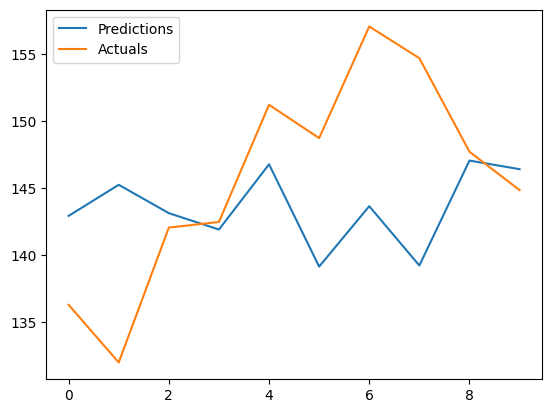

,y_predicted_price,y_actual_price
0,142.933411,136.31
1,145.245560,132.02
2,143.133057,142.06
3,141.916229,142.48
4,146.771439,151.20
5,139.154922,148.72
6,143.653564,157.03
7,139.237930,154.67
8,147.047379,147.71
9,146.408691,144.85


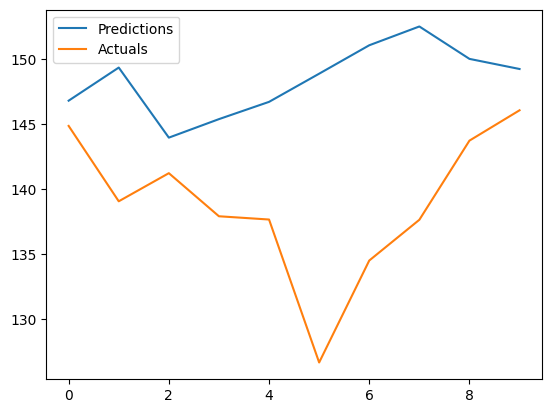

,y_predicted_price,y_actual_price
0,146.788025,144.85
1,149.331329,139.06
2,143.949478,141.22
3,145.371262,137.91
4,146.697159,137.66
5,148.860901,126.68
6,151.043747,134.51
7,152.487228,137.64
8,149.998230,143.72
9,149.221695,146.05


In [25]:
test_predictions_unscaled = scaler_labels.inverse_transform(test_predictions)
y_test_unscaled = scaler_labels.inverse_transform(y_test)
for i in [1, 10]:  
    plot_predictions(test_predictions_unscaled[i], y_test_unscaled[i], num_predictions)
    predictions_table(test_predictions_unscaled[i], y_test_unscaled[i], num_predictions)

### Train model also on test set before deploying

In [26]:
model.fit(X_test, y_test, validation_data=(X_test, y_test), epochs=500, callbacks=[cp2])

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0184 - mean_squared_error: 0.0185 - r2_score: -0.1692 - val_loss: 0.0180 - val_mean_squared_error: 0.0191 - val_r2_score: -0.0650
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - r2_score: -0.0761 - val_loss: 0.0154 - val_mean_squared_error: 0.0162 - val_r2_score: 0.0863
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - r2_score: 0.0856 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_r2_score: 0.3130
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - r2_score: 0.2787 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_r2_score: 0.4498
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - r2_score: 0.5062 - val_loss: 0.0079 - val_mean_squared_error: 0.0078 - val_r2_score: 0.5348
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - r2_score: 0.9016 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_r2_score: 0.9071
Epoch 453/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - r2_score: 0.8970 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_r2_score: 0.9073
Epoch 454/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - r2_score: 0.9081 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_r2_score: 0.9073
Epoch 455/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - r2_score: 0.9092 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_r2_score: 0.9074
Epoch 456/500


## Save model on registry

In [27]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

In [28]:
model_dir = "solana_price_model_10d/"
scalers_dir = "solana_price_10d_scalers/"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)
if not os.path.exists(scalers_dir):
    os.mkdir(scalers_dir)

In [29]:
mr = project.get_model_registry()


# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()


sample_indices = np.random.choice(X_test.shape[0], size=17, replace=False)
sample_test_values = X_test[sample_indices]


solana_model = mr.python.create_model(
    name="solana_price_daily_model_10d", 
    metrics= res_dict_test,
    model_schema=model_schema,
    input_example=sample_test_values, 
    version=3,
    description="Solana daily price predictor. Predicts 10 days using solana lagged 30 timesteps, bitcoin lagged price (10) and fear greed index",
)
if not test_mode:
    model.save(model_dir + "best_model.keras")
    joblib.dump(scaler_features, 'scaler_features.pkl')
    joblib.dump(scaler_labels, 'scaler_labels.pkl')
    solana_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/52946 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/881 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/881 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/96651 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/219 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1160346/models/solana_price_daily_model_10d/3


In [32]:

min_max_scaler = fs.create_transformation_function(
        transformation_function="min_max_scaler",
        description="Scales features to a range between 0 and 1",
        version=1
    )

min_max_scaler.save()

TypeError: create_transformation_function() got an unexpected keyword argument 'description'